<b>Importing Required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

<b>Reading datafiles

In [4]:
movies_pd=pd.read_csv('C:\\Users\\ranga\\OneDrive\\Desktop\\MovieLen Project\\ml-25m\\ml-25m\\movies.csv')
rates_pd =pd.read_csv('C:\\Users\\ranga\\OneDrive\\Desktop\\MovieLen Project\\ml-25m\\ml-25m\\ratings.csv')
links_pd=pd.read_csv('C:\\Users\\ranga\\OneDrive\\Desktop\\MovieLen Project\\ml-25m\\ml-25m\\links.csv')
tags_pd=pd.read_csv('C:\\Users\\ranga\\OneDrive\\Desktop\\MovieLen Project\\ml-25m\\ml-25m\\tags.csv')
genome_scores_pd=pd.read_csv('C:\\Users\\ranga\\OneDrive\\Desktop\\MovieLen Project\\ml-25m\\ml-25m\\genome-scores.csv')
genome_tags_pd=pd.read_csv('C:\\Users\\ranga\\OneDrive\\Desktop\\MovieLen Project\\ml-25m\\ml-25m\\genome-tags.csv')

<b>Checking the data of each file

In [5]:
movies_pd.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
rates_pd.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
links_pd.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
tags_pd.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [9]:
genome_scores_pd.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [10]:
genome_tags_pd.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


<b>We convert timestamp to normal date form and only extract years.

In [11]:
import datetime
def convert_time(timestamp):
    date=datetime.datetime.fromtimestamp(
    int(timestamp)).strftime('%Y-%m-%d %H:%M:%S')
    return int(date[0:4])
rates_pd['year']=rates_pd['timestamp'].apply(convert_time)

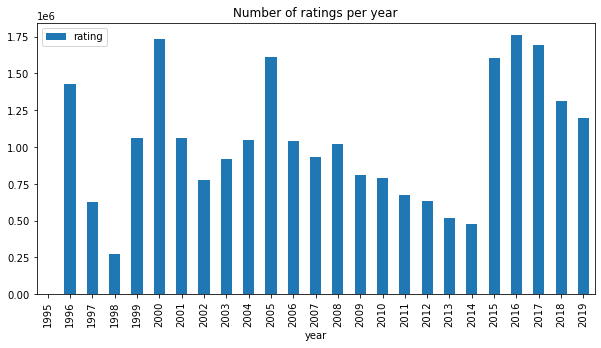

In [12]:
rates_pd[['year', 'rating']].groupby(['year']).count().reset_index().plot.bar(x='year', y='rating', title='Number of ratings per year', figsize=(10, 5));

In [14]:
import datetime
def get_month(timestamp):
    date=datetime.datetime.fromtimestamp(
    int(timestamp)).strftime('%Y-%m-%d %H:%M:%S')
    return int(date[5:7])
rates_pd['month']=rates_pd['timestamp'].apply(get_month)

In [15]:
rates_pd.head()

,userId,movieId,rating,timestamp,year,month
0,1,296,5.0,1147880044,2006,5
1,1,306,3.5,1147868817,2006,5
2,1,307,5.0,1147868828,2006,5
3,1,665,5.0,1147878820,2006,5
4,1,899,3.5,1147868510,2006,5


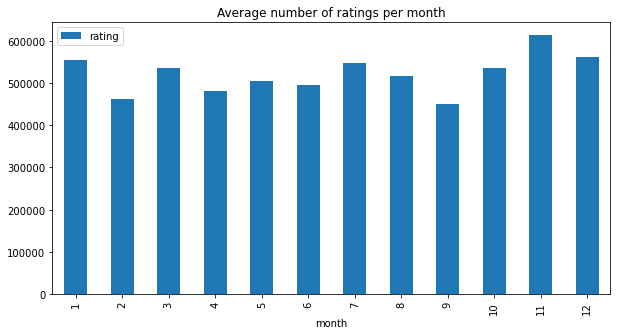

In [16]:
df_temp = rates_pd[['month', 'rating']].groupby(['month']).count().reset_index()
df_temp['rating'] = df_temp['rating'] / 4
df_temp.plot.bar(x='month', y='rating', title='Average number of ratings per month', figsize=(10, 5));

<b>Next, we calculate the average rating over all movies in each year.

In [14]:
avg_rates_year=rates_pd[['year','rating']].groupby('year').mean()

<b>We extract the publication years of all movies.

In [16]:
def year(title):
    year=re.search(r'\(\d{4}\)', title)
    if year:
       year=year.group()
       return int(year[1:5])
    else:
        return 0
movies_pd['year']=movies_pd['title'].apply(year)

<b>Since there are some titles in movies_pd don’t have year, the years we extracted in the way above are not valid. We set year to be 0 for those movies.

In [17]:
sub=movies_pd[movies_pd['year']!=0]

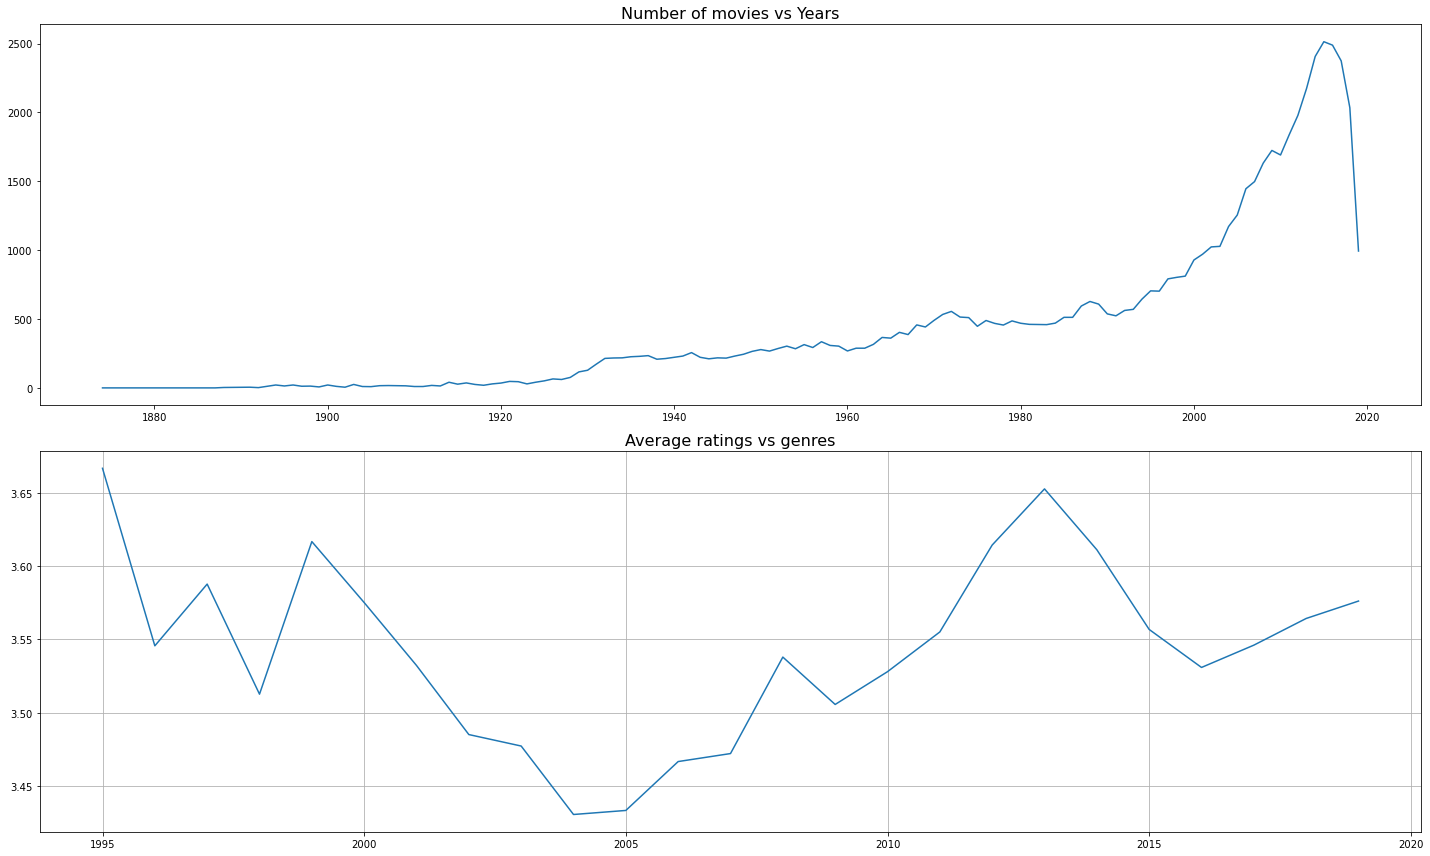

In [20]:
fig1, (ax3,ax4) = plt.subplots(2,1,figsize=(20,12))
plt.subplot(211)
plt.plot(sub.groupby(['year']).count()['title'])
plt.title('Number of movies vs Years',fontsize=16)
 
plt.subplot(212)
a2=plt.plot(avg_rates_year)
plt.title('Average ratings vs genres',fontsize=16)
plt.grid(True)
plt.tight_layout()
fig1.savefig('Number of Movies and average ratings VS years.jpg')

<b>The picture shows that there is a great increment of the movies after 2009. But the average ratings over all movies in each year vary not that much, just from 3.40 to 3.7.

<b>Next we extract all genres for all movies. That is, for a given genre, we would like to know which movies belong to it.

In [22]:
import re
def genres_str(x):
    if x=='(no genres listed)':
        keys=['no_genres']
    else:
        keys= re.sub('[|]', ' ', x)
        keys=keys.split()
    return keys
movies_pd['genres_split']=movies_pd['genres'].apply(genres_str)
 
all_genres=['Action','Adventure','Animation',"Children",
 "Comedy","Crime","Documentary","Drama",
 "Fantasy",'Film-Noir','Horror','Musical',
 'Mystery','Romance','Sci-Fi','Thriller',
 'War','Western','IMAX','no_genres']
values=[]
for i in range(len(all_genres)):
    values.append([])
genres_classify=dict(zip(all_genres, values))
 
for i in range(movies_pd.shape[0]):
     for genre in movies_pd.loc[i,'genres_split']:
         genres_classify[genre].append(movies_pd.loc[i,'movieId'])


<b>Now we can consider the  distributions of the ratings for each genre.

In [23]:
data=[]
for g in all_genres:
    sub=np.array(rates_pd[rates_pd['movieId'].isin(genres_classify[g])].rating)
    data.append(sub)

C:\Users\ranga\AppData\Local\Temp/ipykernel_19184/661448954.py:4: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Boxplot of Movie Ratings VS Genres')


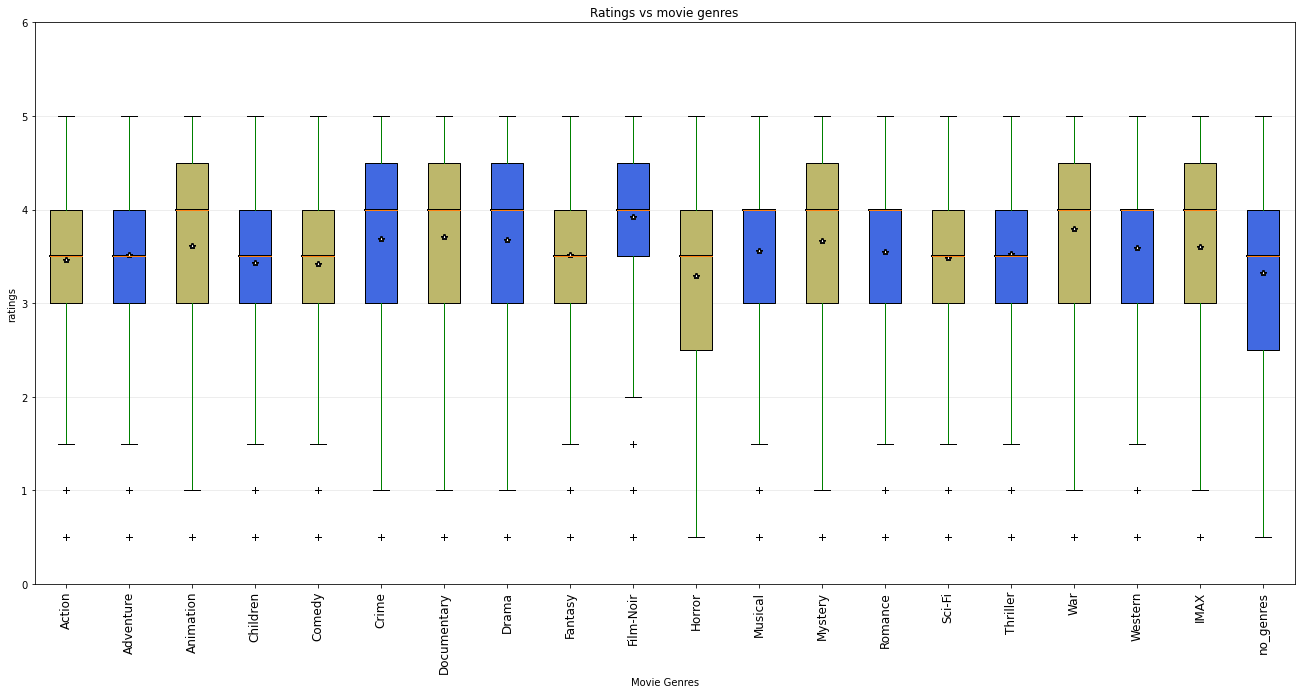

In [26]:
from matplotlib.patches import Polygon

fig, ax1 = plt.subplots(figsize=(20, 12))
fig.canvas.set_window_title('Boxplot of Movie Ratings VS Genres')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
 
bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')


ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
 alpha=0.5)
 

ax1.set_axisbelow(True)
ax1.set_title('Ratings vs movie genres')
ax1.set_xlabel('Movie Genres')
ax1.set_ylabel('ratings')
 
boxColors = ['darkkhaki', 'royalblue']
plt.setp(bp['whiskers'], color='green')
numBoxes=20
 
medians = list(range(numBoxes))
for i in range(numBoxes):
 box = bp['boxes'][i]
 boxX = []
 boxY = []
 for j in range(5):
     boxX.append(box.get_xdata()[j])
     boxY.append(box.get_ydata()[j])
     boxCoords = list(zip(boxX, boxY))
     k = i % 2
     boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
     ax1.add_patch(boxPolygon)
     med = bp['medians'][i]
     medianX = []
     medianY = []
     for j in range(2):
         medianX.append(med.get_xdata()[j])
         medianY.append(med.get_ydata()[j])
         plt.plot(medianX, medianY, 'k')
         medians[i] = medianY[0]
         plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
         color='w', marker='*', markeredgecolor='k')

ax1.set_xlim(0.5, numBoxes + 0.5)
top = 6
bottom = 0
ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=all_genres)
plt.setp(xtickNames, rotation=90, fontsize=12)
plt.savefig('genres_ratings.png')

<b>Next we make ranks by the number of movies in different genres and the number of ratings for all genres.

In [29]:
import operator
common={}
for g in genres_classify:
 common[g]=len(genres_classify[g])
common_sort= sorted(common.items(), key=operator.itemgetter(1))
common_pd=pd.DataFrame(common.items(),columns=['genre', 'numbers'])
common_pd

,genre,numbers
0,Action,7348
1,Adventure,4145
2,Animation,2929
3,Children,2935
4,Comedy,16870
5,Crime,5319
6,Documentary,5605
7,Drama,25606
8,Fantasy,2731
9,Film-Noir,353


<b>We can see that Drama is the most common genre; Comedy is the second. The most uncommon genre is Film-Noir.

In [32]:
popular={}
i=0
for g in genres_classify:
 popular[g]=len(data[i])
 i+=1
popular_sort= sorted(popular.items(), key=operator.itemgetter(1))
popular_sort
popular_pd=pd.DataFrame(popular.items(),columns=['genre', 'number of ratings'])
popular_pd.head()
summary_genre=popular_pd.merge(common_pd,on='genre',how='inner')
summary_genre

,genre,number of ratings,numbers
0,Action,7446918,7348
1,Adventure,5832424,4145
2,Animation,1630987,2929
3,Children,2124258,2935
4,Comedy,8926230,16870
5,Crime,4190259,5319
6,Documentary,322449,5605
7,Drama,10962833,25606
8,Fantasy,2831585,2731
9,Film-Noir,247227,353


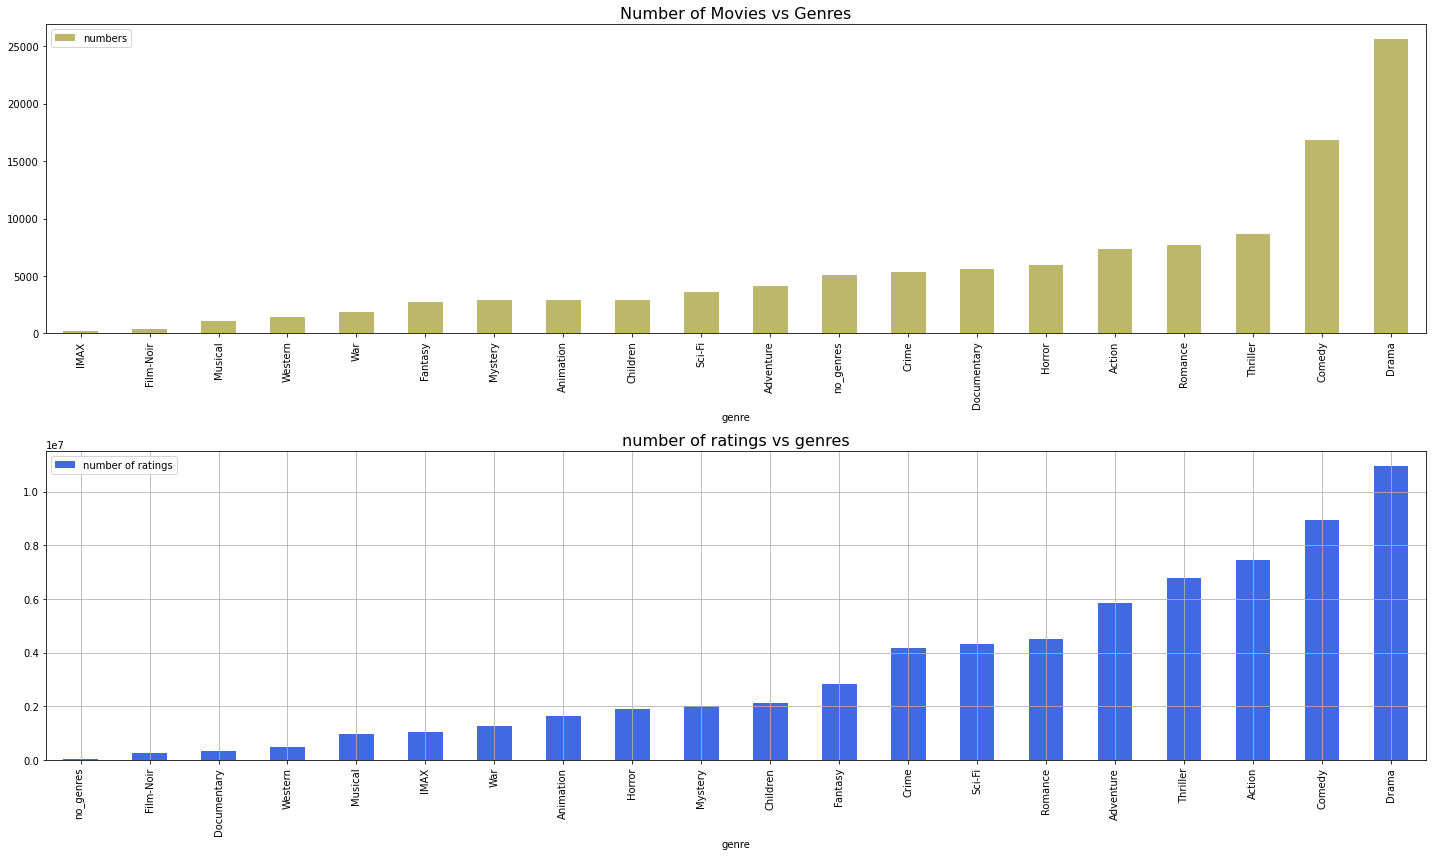

In [33]:
sort_1=summary_genre.sort_values(by='numbers')
sort_2=summary_genre.sort_values(by='number of ratings')
 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
 
a1=sort_1.plot.bar(x='genre',y='numbers',ax=ax1,color='darkkhaki')
a1.set_title('Number of Movies vs Genres',fontsize=16)
plt.grid(True)
 
a2=sort_2.plot.bar(x='genre',y='number of ratings',ax=ax2,color='royalblue')
a2.set_title('number of ratings vs genres',fontsize=16)
plt.grid(True)
plt.tight_layout()
 
fig.savefig('Number of Movies and Number of Ratings by genres.jpg')

<b>Finally, we explore the users ratings for all movies and sketch the heatmap for popular movies and active users.

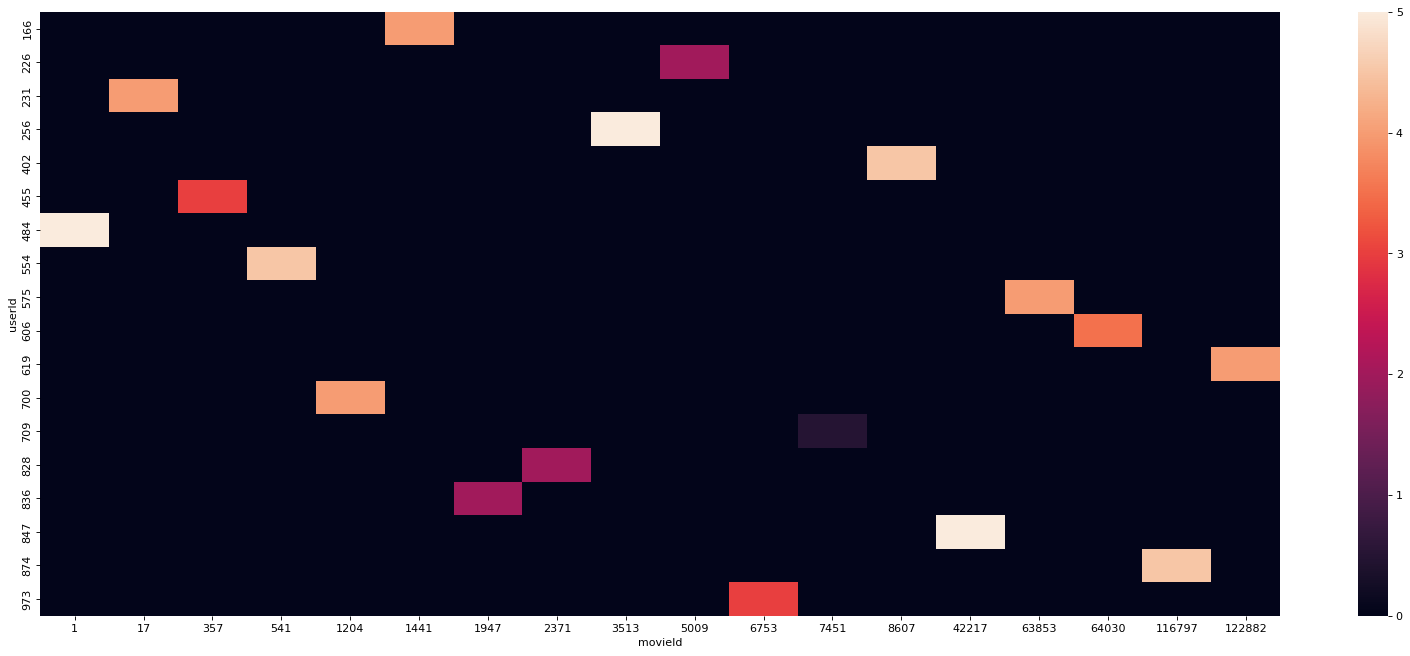

In [37]:
summary_2=rates_pd['rating'].groupby(rates_pd['userId'])
user_counts=summary_2.count().to_dict()
user_counts=pd.DataFrame(user_counts.items(), columns=['userId', 'count'])
active_users=user_counts[user_counts['count']>5000]
INDEX1=active_users.index
popular_movies=user_counts[user_counts['count']>25000]
INDEX2=popular_movies.index
INDEX=list(set(INDEX1).union(set(INDEX2)))
rates_pd_sub=rates_pd.iloc[INDEX,]
table = pd.pivot_table(rates_pd_sub, values='rating', index=['movieId'],
columns=['userId'], aggfunc=np.sum)
table_pd=pd.DataFrame(table.fillna(0))
table_pd.transpose()

plt.figure(num=None, figsize=(25,10), dpi=80, facecolor='w', edgecolor='k')
heatmap=sns.heatmap(table_pd.transpose())